# AIM Hackathon: Sample code
19.10.2024

In [3]:
import os
import requests
import PyPDF2
import tiktoken
import pandas as pd
import pickle
from dotenv import load_dotenv
from tqdm import tqdm

from langchain_openai import ChatOpenAI
from langchain_core.documents import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_openai.embeddings.base import OpenAIEmbeddings

from langchain.prompts import PromptTemplate
from langchain.chains import RetrievalQA
from langchain.vectorstores import FAISS

from Cryptodome.Cipher import AES

from typing import Optional, List, Union
from pydantic import BaseModel
from openai import OpenAI
import warnings

# Suppress only LangChainDeprecationWarning
warnings.filterwarnings("ignore", category=DeprecationWarning, module="langchain")
warnings.filterwarnings("ignore", message="Importing FAISS from langchain.vectorstores is deprecated. Please replace deprecated imports")
# load openai key
if not load_dotenv():
    raise Exception('Error loading .env file. Make sure to place a valid OPEN_AI_KEY in the .env file.')

In [4]:
REPORTS_SAVE_PATH = 'data/sample_reports'
DB_PATH = "data/db/sample.db"

# See https://openai.com/api/pricing/
MODEL = "gpt-4o"

In [5]:
df = pd.read_json('data/reports.json')
df

,company_name,year,dataset,pdf_url
0,Walmart,2023,handcrafted,https://corporate.walmart.com/content/dam/corp...
1,Walmart,2021,handcrafted,https://corporate.walmart.com/content/dam/corp...
2,Walmart,2019,handcrafted,https://corporate.walmart.com/content/dam/corp...
3,Amazon,2023,handcrafted,https://sustainability.aboutamazon.com/content...
4,Amazon,2021,handcrafted,https://sustainability.aboutamazon.com/content...
...,...,...,...,...
141,tarkett,2020,scraped,https://www.tarkett.com/sites/default/files/20...
142,trivium-packaging,2021,scraped,https://www.triviumpackaging.com/media/13fl4q3...
143,trivium-packaging,2020,scraped,https://triviumpackaging.com/sustainability/re...
144,trust,2023,scraped,https://dezlwerqy1h00.cloudfront.net/images/co...


## Download some reports

In [6]:
# EXAMPLE: select apple reports
df_sample = df[df['dataset']=='handcrafted']

In [7]:
# Storing the encryption keys for further decryption
enc_keys = []

# download Apple reports to save_dir
def download_files(df: pd.DataFrame, save_dir: str):
    os.makedirs(save_dir, exist_ok=True)
    for url in df['pdf_url']:
        pdf_filename = os.path.basename(url)
        # Checking if the file is encrypted
        if('?' in pdf_filename):
            # Saving the password for decryption
            enc_keys.append(pdf_filename)
            # Removing question mark
            pdf_filename = pdf_filename.split('?')[0]
            
        response = requests.get(url)
        with open(os.path.join(save_dir, pdf_filename), 'wb') as file:
            file.write(response.content)
    print(f"Success.")

In [8]:
download_files(df_sample, REPORTS_SAVE_PATH)

Success.


## Create simple vector database

In [9]:
def get_password(f):
    for tmp in enc_keys:
        if(f == tmp.split()[0]):
            return tmp

def get_documents_from_path(files_path: str) -> [Document]:
    documents = []
    
    for file in os.listdir(files_path):
        _, file_extension = os.path.splitext(file)
        text = ""
        
        if file_extension == ".pdf":
            with open(os.path.join(files_path, file), 'rb') as f:
                reader = PyPDF2.PdfReader(f, strict=False)
                
                if reader.is_encrypted:
                    try:
                        # Try to decrypt with the provided password (or an empty string if no password is given)
                        pdf_password = get_password(file)
                        
                        if pdf_password:
                            success = reader.decrypt(pdf_password)
                        else:
                            success = reader.decrypt("")

                        if success == 0:
                            print(f"Failed to decrypt {file}: Invalid password.")
                            continue  # Skip file if decryption fails
                        else:
                            print(f"Decrypted {file} successfully.")
                    except Exception as e:
                        print(f"Failed to decrypt {file}: {e}")
                        continue  # Skip file if decryption fails
                for page in reader.pages:
                    text += page.extract_text() + "\n"
                
            if text:
                documents.append(Document(page_content=text, metadata={"source": file}))
            else:
                print(f"WARNING: No text extracted from {file}")
        else:
            # TODO: can add support for other file types here
            raise Exception(f"Unsupported file extension: {file_extension}")
    
    return documents

In [10]:
documents = get_documents_from_path(REPORTS_SAVE_PATH)

Decrypted 2023_Volkswagen_Group_Sustainability_Report.pdf successfully.
Decrypted bp-sustainability-report-2021.pdf successfully.
Decrypted bp-sustainability-report-2023.pdf successfully.
Decrypted Nonfinancial_Report_2021_en.pdf successfully.


In [11]:
# TODO could also just provide a dummy retriever to not spoil too much
class DummyRetriever:
    def __init__(self, texts):
        self.texts = texts
        
    def dummy_retriever(self, query):
        import random
        return random.sample(self.texts, k=3)

In [12]:
# Create database
text_splitter = RecursiveCharacterTextSplitter(chunk_size=3000, chunk_overlap=300, separators=["\n\n", "\n"])

# split documents and create vector database
texts = text_splitter.split_documents(documents)
embeddings = OpenAIEmbeddings()  # https://platform.openai.com/docs/guides/embeddings/embedding-models
db = FAISS.from_documents(texts, embeddings)

# count build embedding token number
tokenizer = tiktoken.get_encoding("cl100k_base")
build_token_count = sum([len(tokenizer.encode(doc.page_content)) for doc in texts])
print(f"Token count: {build_token_count}")

Token count: 1286489


In [14]:
# Store the database
with open(DB_PATH, "wb") as f:
    pickle.dump(db.serialize_to_bytes(), f)

## Create simple RAG

In [15]:
# Load the database
DB_PATH = "data/db/sample.db"

with open(DB_PATH, "rb") as f:
    db_bytes = pickle.load(f)
    db = FAISS.deserialize_from_bytes(db_bytes, OpenAIEmbeddings(), allow_dangerous_deserialization=True)

In [50]:
client = OpenAI()

retriever=db.as_retriever()

class Answer(BaseModel):
    value: Optional[List[Union[float, int]]]
    unit: str
    chain_of_thought: str

def retrieve_context(question):
    context_docs = retriever.get_relevant_documents(question)
    context = '\n'.join([doc.page_content for doc in context_docs])
    return context

def construct_messages(context, question):
    system_prompt = (
        "You are an expert assistant. Use only the following retrieved context to answer the question accurately and concisely. "
        "Provide your answer as a number followed by its unit, without any additional text or explanation. "
        "Before giving the final answer, include your chain-of-thought reasoning prefixed with 'Chain of Thought:'. "
        "If nothing is mentioned in the context, say 'I don't know'."
    )
    
    messages = [
        {"role": "system", "content": system_prompt},
        {"role": "user", "content": f"Context:\n{context}\n\nQuestion:\n{question}"}
    ]
    return messages

def get_response_from_openai(question, verbose=True):
    context = retrieve_context(question)
    messages = construct_messages(context, question)
    completion = client.beta.chat.completions.parse(
        model=MODEL,
        messages=messages,
        response_format=Answer
        )
    answer = completion.choices[0].message.parsed

    if verbose:
        if answer.value is not None:
            print(f"Value: {answer.value}")
            print(f"Unit: {answer.unit}")
            print(f"Chain of Thought: {answer.chain_of_thought}")
        else:
            print("Cannot answer.")
            print(f"Chain of Thought: {answer.chain_of_thought}")

    return answer


In [28]:
esg_metrics = [
    'Carbon Emissions',
    'Energy Consumption',
    'Water Usage',
    'Waste Generation',
    'Renewable Energy Usage',
    'Greenhouse Gas Emissions Intensity',
    'Biodiversity Impact',
    'Air Pollutant Emissions',
    'Environmental Management System',
    'Supply Chain Environmental Impact',
    'Employee Turnover Rate',
    'Gender Diversity Ratio',
    'Employee Health and Safety Incidents',
    'Labor Practices',
    'Human Rights Compliance',
    'Community Engagement Initiatives',
    'Customer Satisfaction Score',
    'Data Privacy Breaches',
    'Product Safety Incidents',
    'Board Diversity',
    'Executive Compensation Ratio',
    'Shareholder Rights',
    'Anti-Corruption Policies',
    'Regulatory Compliance',
    'Ethical Supply Chain Management',
    'Stakeholder Engagement',
    'Risk Management Strategies',
    'Transparency and Disclosure Practices',
    'Climate Change Risks and Opportunities',
    'Innovation and R&D Investment'
]


In [74]:
esg_metrics2 = [

    'Renewable Energy Usage',
    'Greenhouse Gas Emissions Intensity',
    'Biodiversity Impact',
    'Air Pollutant Emissions',
    'Environmental Management System',
    'Supply Chain Environmental Impact',
    'Employee Turnover Rate',
    'Gender Diversity Ratio',
    'Employee Health and Safety Incidents',
    'Labor Practices',
    'Human Rights Compliance',
    'Community Engagement Initiatives',
    'Customer Satisfaction Score',
    'Data Privacy Breaches',
    'Product Safety Incidents',
    'Board Diversity',
    'Executive Compensation Ratio',
    'Shareholder Rights',
    'Anti-Corruption Policies',
    'Regulatory Compliance',
    'Ethical Supply Chain Management',
    'Stakeholder Engagement',
    'Risk Management Strategies',
    'Transparency and Disclosure Practices',
    'Climate Change Risks and Opportunities',
    'Innovation and R&D Investment'
]


In [51]:
get_response_from_openai(f"in which years do we have data on co2 emission for Apple?")

Value: [2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018]
Unit: year
Chain of Thought: The data on CO2 emission for Apple is provided for the fiscal years 2011, 2012, 2013, 2014, 2015, 2016, 2017, and 2018 in the context.


Answer(value=[2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018], unit='year', chain_of_thought='The data on CO2 emission for Apple is provided for the fiscal years 2011, 2012, 2013, 2014, 2015, 2016, 2017, and 2018 in the context.')

In [75]:
# Initialize the final DataFrame
df_final2 = pd.DataFrame(columns=["company", "year", "metric", "value", "unit"])

# Display the available companies
companies = set(df_sample.company_name)
print(f"The companies are: {', '.join(companies)}")

# Initialize variables
add_more_metrics = True
all_metrics = False

# Prompt the user to enter a metric or 'all'
while True:
    metric_input = input("Please enter a metric you are interested in. If you need some tips, type 'help'. To use all metrics, type 'all'.\nMetric: ").strip()
    if metric_input.lower() == "help":
        print("\nAvailable ESG metrics:")
        print(', '.join(esg_metrics))
        print()
    elif metric_input.lower() == "all":
        all_metrics = True
        metrics_list = esg_metrics2  # Use all metrics
        break
    else:
        metrics_list = [metric_input]
        break

# Main loop to collect data
while add_more_metrics:
    for metric in metrics_list:
        # Iterate over companies and collect data
        for company in companies:
            years_response = get_response_from_openai(f"In which years do we have data on {metric} for {company}?")
            if years_response.value is not None:
                # Clean and split the years
                years_list = years_response.value
                for year in years_list:
                    response = get_response_from_openai(f"In {year}, what is the {metric} for {company}?")
                    if response.value is not None:
                        print(f"{company} ({year}) - {metric}: {response}")
                        value, unit = response.value, response.unit
                        # Create a new row and append it to df_final
                        new_row = {
                            "company": company,
                            "year": year,
                            "metric": metric,
                            "value": value,
                            "unit": unit
                        }
                        df_final2 = pd.concat([df_final2, pd.DataFrame([new_row])], ignore_index=True)

    # If 'all' was selected, no need to ask for more metrics
    if all_metrics:
        add_more_metrics = False
    else:
        # Ask if the user wants to add another metric
        while True:
            continue_input = input("Do you want to add another metric? (yes/no): ").strip().lower()
            if continue_input in ['yes', 'no']:
                break
            else:
                print("Please enter 'yes' or 'no'.\n")

        if continue_input == 'no':
            add_more_metrics = False
        else:
            # Prompt the user to enter the next metric
            while True:
                metric_input = input("Please enter the next metric you are interested in. If you need some tips, type 'help'.\nMetric: ").strip()
                if metric_input.lower() == "help":
                    print("\nAvailable ESG metrics:")
                    print(', '.join(esg_metrics))
                    print()
                else:
                    metrics_list = [metric_input]
                    break


The companies are: Amazon, H&M, Apple, BP, Walmart, Saudi Aramco, Google, Volkswagen
Value: [2021]
Unit: year
Chain of Thought: The provided context mentions, "In 2021, we reached 85% renewable energy across our business," which indicates that data on renewable energy usage for Amazon is available for the year 2021.
Value: [85]
Unit: %
Chain of Thought: According to the context given, in 2021, Amazon reached 85% renewable energy across its business.
Amazon (2021) - Renewable Energy Usage: value=[85] unit='%' chain_of_thought='According to the context given, in 2021, Amazon reached 85% renewable energy across its business.'
Value: [2019]
Unit: year(s)
Chain of Thought: Chain of Thought: The data for renewable energy usage in H&M operations is provided for the year 2019 in the document, mentioning a usage of 96%. Therefore, the only available year for renewable energy usage data is 2019.
Value: [96]
Unit: %
Chain of Thought: From the context, it is mentioned that in 2019, 96% of the elec

In [76]:
df_filtered.csv_to("data/df_filtered.csv")

AttributeError: 'DataFrame' object has no attribute 'csv_to'

In [65]:
df_final.head(9)

,company,year,metric,value,unit
0,Amazon,2022,Carbon Emissions,[70.74],metric tons CO2e
1,H&M,2016,Carbon Emissions,"[10376, 70165]",tonnes
2,H&M,2017,Carbon Emissions,[70165],tonnes
3,H&M,2018,Carbon Emissions,"[6352, 775, 71, 62, 63]",ktonnes
4,H&M,2019,Carbon Emissions,"[10, 376, 70, 165, 80, 541, 12, 484, 51, 206, ...",tonnes
5,Apple,2012,Carbon Emissions,[400000],metric tons CO2e
6,Apple,2011,Carbon Emissions,[200000],metric tons CO2e
7,BP,2017,Carbon Emissions,[48.8],MteCO2e
8,BP,2018,Carbon Emissions,"[46.5, 5.7]",MteCO2e


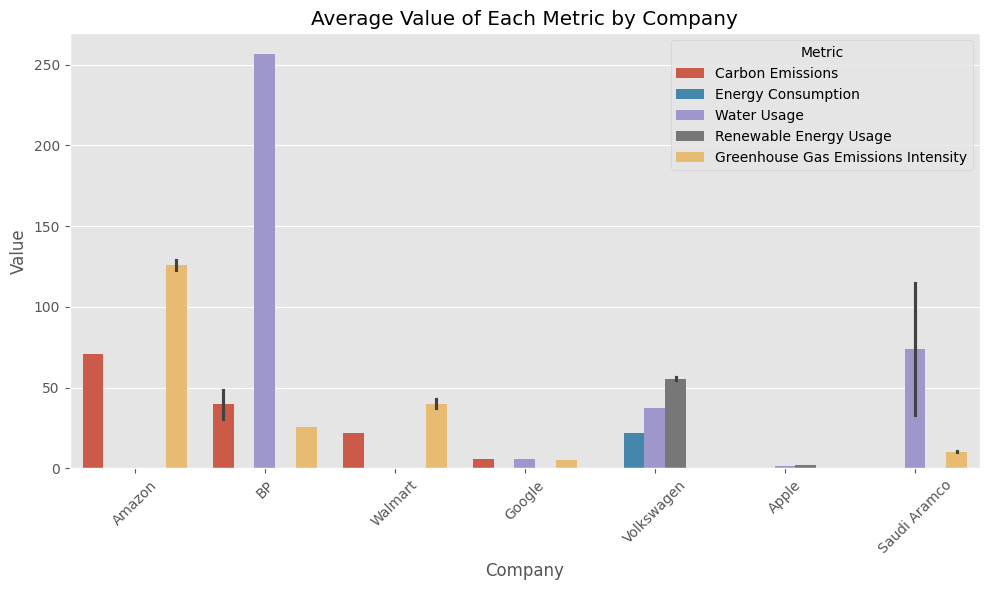

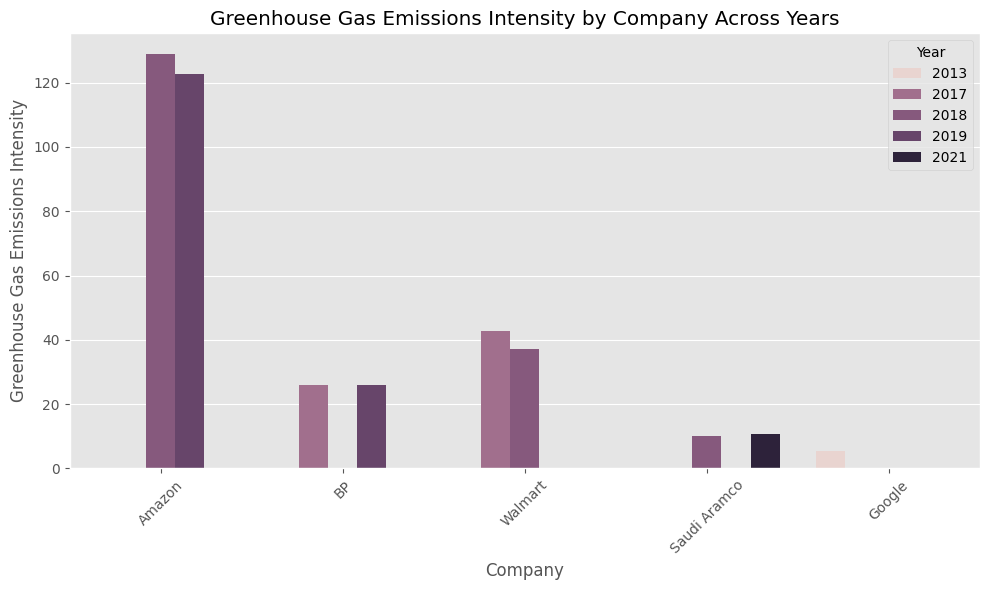

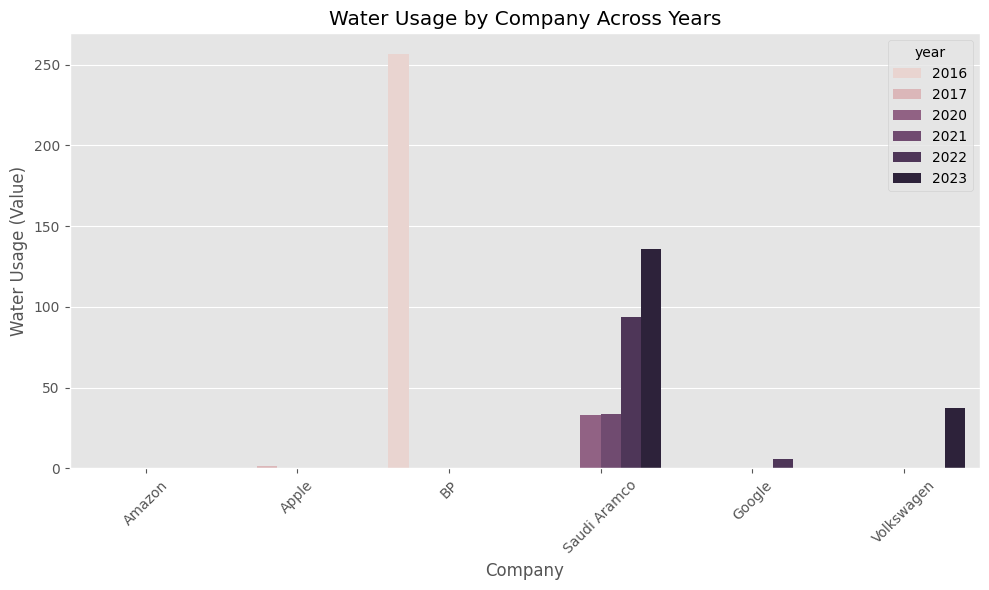

In [69]:
import matplotlib.pyplot as plt
import seaborn as sns

df_filtered = df_final[df_final['value'].apply(lambda x: isinstance(x, list) and len(x) == 1 and isinstance(x[0], float))]

# Step 2: Convert the list with one float into a float value
df_filtered['value'] = df_filtered['value'].apply(lambda x: x[0])

# Set the plot style for a cleaner look
plt.style.use('ggplot')

# Plot 1: Average value of each metric by company
plt.figure(figsize=(10, 6))
sns.barplot(data=df_filtered, x='company', y='value', hue='metric')
plt.title('Average Value of Each Metric by Company')
plt.xlabel('Company')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()



# Plot 2: Comparison of Greenhouse Gas Emissions Intensity by company
greenhouse_gas_df = df_filtered[df_filtered['metric'] == 'Greenhouse Gas Emissions Intensity']

plt.figure(figsize=(10, 6))
sns.barplot(data=greenhouse_gas_df, x='company', y='value', hue='year')
plt.title('Greenhouse Gas Emissions Intensity by Company Across Years')
plt.xlabel('Company')
plt.ylabel('Greenhouse Gas Emissions Intensity')
plt.xticks(rotation=45)
plt.legend(title='Year')
plt.tight_layout()
plt.show()


# Plot 3: Water Usage across companies
water_usage_df = df_filtered[df_filtered['metric'] == 'Water Usage']

plt.figure(figsize=(10, 6))
sns.barplot(data=water_usage_df, x='company', y='value', hue='year')
plt.title('Water Usage by Company Across Years')
plt.xlabel('Company')
plt.ylabel('Water Usage (Value)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

